In [1]:
import cv2
import numpy as np

In [15]:
from pypylon import pylon
import time

camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()


# demonstrate some feature access
new_width = camera.Width.Value - camera.Width.Inc
if new_width >= camera.Width.Min:
    camera.Width.Value = new_width

numberOfImagesToGrab = 50
camera.StartGrabbingMax(numberOfImagesToGrab)
img = pylon.PylonImage()
i = 0
while camera.IsGrabbing():
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    img.AttachGrabResultBuffer(grabResult)
    if grabResult.GrabSucceeded():
        # Access the image data.
        # print("SizeX: ", grabResult.Width)
        # print("SizeY: ", grabResult.Height)
        # img = grabResult.Array
        # print("Gray value of first pixel: ", img[0, 0])

        ipo = pylon.ImagePersistenceOptions()
        quality = 100 - i * 1
        ipo.SetQuality(quality)

        filename = "./test/saved_pypylon_img_%d.jpeg" % quality
        img.Save(pylon.ImageFileFormat_Jpeg, filename, ipo)
    
    i += 1
    time.sleep(1)

    grabResult.Release()
camera.Close()

### Camera Settings

In [4]:

# phone cam
camera_matrix = np.array([[2.84824695e+03, 0.00000000e+00, 2.02041904e+03],
        [0.00000000e+00, 2.85001000e+03, 1.51079453e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])



# Cam Cam
camera_matrix_cam = 0




In [2]:
img1 = cv2.imread('Imgs/4.png')
img2 = cv2.imread('Imgs/5.png')
img3 = cv2.imread('Imgs/6.png')

In [3]:
img7 = cv2.imread('Imgs/7.png')
img8 = cv2.imread('Imgs/8.png')
img9 = cv2.imread('Imgs/9.png')
img10 = cv2.imread('Imgs/10.png')
img11 = cv2.imread('Imgs/11.png')
img12 = cv2.imread('Imgs/12.png')
img13 = cv2.imread('Imgs/13.png')

In [4]:
stitcher = cv2.Stitcher_create()

(status, panorama) = stitcher.stitch([img7, img8, img9, img10, img11, img12, img13])

In [11]:
if status == cv2.Stitcher_OK:
    cv2.imshow('Panorama', panorama)
    # cv2.moveWindow("Panorama", -,-800)
    cv2.imwrite("Output.png", panorama)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error stitching images")
    

In [9]:
status

1

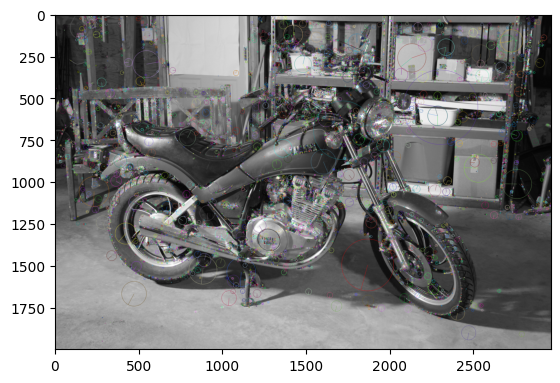

In [7]:
import cv2 as cv 
import numpy as np 
import matplotlib.pyplot as plt 
import os 


def SIFT(): 
    # root = os.getcwd()
    # imgPath = os.path.join(root,'demoImages//tesla.jpg')
    # imgGray = cv.imread(imgPath,cv.IMREAD_GRAYSCALE)
    imgGray = cv2.imread('./Imgs/Bike/im1.png', cv.IMREAD_GRAYSCALE)

    sift = cv.SIFT_create()
    keypoints = sift.detect(imgGray,None)
    imgGray = cv.drawKeypoints(imgGray,keypoints,imgGray,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure() 
    plt.imshow(imgGray)
    
    plt.show() 

if __name__ == '__main__': 
    SIFT() 

### Working Code

In [10]:

import cv2
import numpy as np


def Reprojection3D(image, disparity, f, b):
	Q = np.array([[1, 0, 0, -2964/2], [0, 1, 0, -2000/2], [0, 0, 0, f], [0, 0, -1/b, -124.343/b]])

	points = cv2.reprojectImageTo3D(disparity, Q)
	mask = disparity > disparity.min()
	# colors = image
	
	out_points = points[mask]
	out_colors = image[mask]
 
	sampled_indices = np.arange(0, out_points.shape[0], 25)
	out_points = out_points[sampled_indices]
	out_colors = out_colors[sampled_indices]
	
	verts = out_points.reshape(-1,3)
	colors = out_colors.reshape(-1,3).astype(np.uint8)
	verts = np.hstack([verts, colors])
	
	ply_header = '''ply
		format ascii 1.0
		element vertex {vert_num}
		property float32 x
		property float32 y
		property float32 z
		property uchar blue
		property uchar green
		property uchar red
		end_header
		'''.format(vert_num=len(verts)-1)
	with open('stereo.ply', 'w') as f:
		f.write(ply_header)

		# f.write(ply_header.encode('utf-8'))
		np.savetxt(f, verts, fmt='%.2f %.2f %.2f %d %d %d')
		# np.save(f, verts)


# cv2.namedWindow('Disparity', cv2.WINDOW_NORMAL)
# cv2.namedWindow('Left Image', cv2.WINDOW_NORMAL)
# cv2.namedWindow('Right Image', cv2.WINDOW_NORMAL)

K = np.array([[3979.911, 0, 1369.115], [0, 3979.911, 1019.507], [0, 0, 1]], dtype = np.float32)
D = np.zeros((5,1), dtype = np.float32)
downscale = 2
K[0,0] = K[0,0] / float(downscale)
K[1,1] = K[1,1] / float(downscale)
K[0,2] = K[0,2] / float(downscale)
K[1,2] = K[1,2] / float(downscale)

#imgL = cv2.imread('/home/arihant/stereo/im0.png')
#imgR = cv2.imread('/home/arihant/stereo/im1.png')
imgL = cv2.pyrDown(cv2.imread('./Imgs/Bike/im0.png'))
imgR = cv2.pyrDown(cv2.imread('./Imgs/Bike/im1.png'))


imgLgray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgRgray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# Feature Extraction
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(imgLgray, None)
kp2, des2 = sift.detectAndCompute(imgRgray, None)

# Feature Matching and Outlier Rejection
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k = 2)

good = []
for m,n in matches:
	if m.distance < 0.70 * n.distance:
		good.append(m)

print(":::good", len(good))
		
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

E, mask = cv2.findEssentialMat(pts1, pts2, K, method = cv2.RANSAC, prob = 0.999, threshold = 0.4, mask = None)
pts1 = pts1[mask.ravel() ==1]
pts2 = pts2[mask.ravel() ==1]
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

P1 = np.zeros((3,4))
P1 = np.matmul(K, P1)
P2 = np.hstack((R, t))
P2 = np.matmul(K, P2)
points1 = pts1.reshape(2, -1)
points2 = pts2.reshape(2, -1)
#cloud = cv2.triangulatePoints(P1, P2, pts1, pts2).reshape(-1, 4)[:, :3]
#ret, R, t, inliers = cv2.solvePnPRansac(cloud, pts2, K, D, cv2.SOLVEPNP_ITERATIVE)
# print(":::D", D)

R1, R2, P1, P2, Q, a, b = cv2.stereoRectify(K, D, K, D, (1482, 1000), R, t)
map1, map2 = cv2.initUndistortRectifyMap(K, D, R1, P1, (1482, 1000), cv2.CV_16SC2)
imgLrec = cv2.remap(imgL, map1, map2, cv2.INTER_CUBIC)

map3, map4 = cv2.initUndistortRectifyMap(K, D, R2, P2, (1482, 1000), cv2.CV_16SC2)
imgRrec = cv2.remap(imgR, map3, map4, cv2.INTER_CUBIC)

max_disparity = 199
min_disparity = 23
num_disparities = max_disparity - min_disparity
window_size = 5
stereo = cv2.StereoSGBM_create(minDisparity = min_disparity, numDisparities = num_disparities, blockSize = 5, uniquenessRatio = 5, speckleWindowSize = 5, speckleRange = 5, disp12MaxDiff = 2, P1 = 8*3*window_size**2, P2 = 32*3*window_size**2)

stereo2 = cv2.ximgproc.createRightMatcher(stereo)

lamb = 8000
sig = 1.5
visual_multiplier = 1.0
wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo)
wls_filter.setLambda(lamb)
wls_filter.setSigmaColor(sig)

disparity = stereo.compute(imgLrec, imgRrec)

#disparity = np.int16(disparity)
#_, disparity = cv2.threshold(disparity, 0, max_disparity * 16, cv2.THRESH_TOZERO)
#disparity = (disparity / 16).astype(np.uint8)

disparity2 = stereo2.compute(imgRrec, imgLrec)
disparity2 = np.int16(disparity2)

#_, disparity2 = cv2.threshold(disparity2, 0, max_disparity * 16, cv2.THRESH_TOZERO)
#disparity2 = (disparity2 / 16).astype(np.uint8)

filteredImg = wls_filter.filter(disparity, imgL, None, disparity2)
_, filteredImg = cv2.threshold(filteredImg, 0, max_disparity * 16, cv2.THRESH_TOZERO)
filteredImg = (filteredImg / 16).astype(np.uint8)


baseline = 193.001/2
f = 3979.911/2

Reprojection3D(imgL, filteredImg, f, baseline)

# cv2.imshow('Left Image', imgLrec)
# cv2.imshow('Right Image', imgRrec)
# cv2.imshow('Disparity', filteredImg)
cv2.imwrite('match.png', filteredImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

:::good 2350


### Arihant's code for our images

In [18]:
import cv2
import numpy as np


# Camera calibration settings
# K = np.array([[3979.911, 0, 1369.115], [0, 3979.911, 1019.507], [0, 0, 1]], dtype = np.float32)
# 
camera_matrix = np.array([[2.84824695e+03, 0.00000000e+00, 2.02041904e+03],
        [0.00000000e+00, 2.85001000e+03, 1.51079453e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

def Reprojection3D(image, disparity, f, b):
	Q = np.array([[1, 0, 0, -2964/2], [0, 1, 0, -2000/2], [0, 0, 0, f], [0, 0, -1/b, -124.343/b]])

	points = cv2.reprojectImageTo3D(disparity, Q)
	mask = disparity > disparity.min()
	# colors = image

	
	out_points = points[mask]
	out_colors = image[mask]
	
	verts = out_points.reshape(-1,3)
	colors = out_colors.reshape(-1,3).astype(np.uint8)
	verts = np.hstack([verts, colors])
	
	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar blue
		property uchar green
		property uchar red
		end_header
		'''
	with open('stereo.ply', 'w') as f:
		f.write(ply_header %dict(vert_num = len(verts)))
		np.savetxt(f, verts, '%f %f %f %d %d %d')


# cv2.namedWindow('Disparity', cv2.WINDOW_NORMAL)
# cv2.namedWindow('Left Image', cv2.WINDOW_NORMAL)
# cv2.namedWindow('Right Image', cv2.WINDOW_NORMAL)

K = np.array([[2.84824695e+03, 0.00000000e+00, 2.02041904e+03],
        [0.00000000e+00, 2.85001000e+03, 1.51079453e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype = np.float32)
D = np.zeros((5,1), dtype = np.float32)
downscale = 2
K[0,0] = K[0,0] / float(downscale)
K[1,1] = K[1,1] / float(downscale)
K[0,2] = K[0,2] / float(downscale)
K[1,2] = K[1,2] / float(downscale)

imgL = cv2.imread('./Imgs/bott/IMG_20240501_163859159.jpg')
imgR = cv2.imread('./Imgs/bott/IMG_20240501_163906696.jpg')
# imgL = cv2.pyrDown(cv2.imread('./Imgs/Bike/im0.png'))
# imgR = cv2.pyrDown(cv2.imread('./Imgs/Bike/im1.png'))


imgLgray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgRgray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# Feature Extraction
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(imgLgray, None)
kp2, des2 = sift.detectAndCompute(imgRgray, None)

# Feature Matching and Outlier Rejection
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k = 2)

good = []
for m,n in matches:
	if m.distance < 0.70 * n.distance:
		good.append(m)

print(":::good", len(good))
		
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

E, mask = cv2.findEssentialMat(pts1, pts2, K, method = cv2.RANSAC, prob = 0.999, threshold = 0.4, mask = None)
pts1 = pts1[mask.ravel() ==1]
pts2 = pts2[mask.ravel() ==1]
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

P1 = np.zeros((3,4))
P1 = np.matmul(K, P1)
P2 = np.hstack((R, t))
P2 = np.matmul(K, P2)
points1 = pts1.reshape(2, -1)
points2 = pts2.reshape(2, -1)
#cloud = cv2.triangulatePoints(P1, P2, pts1, pts2).reshape(-1, 4)[:, :3]
#ret, R, t, inliers = cv2.solvePnPRansac(cloud, pts2, K, D, cv2.SOLVEPNP_ITERATIVE)

R1, R2, P1, P2, Q, a, b = cv2.stereoRectify(K, D, K, D, (3072, 4080), R, t)
map1, map2 = cv2.initUndistortRectifyMap(K, D, R1, P1, (3072, 4080), cv2.CV_16SC2)
imgLrec = cv2.remap(imgL, map1, map2, cv2.INTER_CUBIC)

map3, map4 = cv2.initUndistortRectifyMap(K, D, R2, P2, (3072, 4080), cv2.CV_16SC2)
imgRrec = cv2.remap(imgR, map3, map4, cv2.INTER_CUBIC)

max_disparity = 199
min_disparity = 23
num_disparities = max_disparity - min_disparity
window_size = 5
stereo = cv2.StereoSGBM_create(minDisparity = min_disparity, numDisparities = num_disparities, blockSize = 5, uniquenessRatio = 5, speckleWindowSize = 5, speckleRange = 5, disp12MaxDiff = 2, P1 = 8*3*window_size**2, P2 = 32*3*window_size**2)

stereo2 = cv2.ximgproc.createRightMatcher(stereo)

lamb = 8000
sig = 1.5
visual_multiplier = 1.0
wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo)
wls_filter.setLambda(lamb)
wls_filter.setSigmaColor(sig)

disparity = stereo.compute(imgLrec, imgRrec)

#disparity = np.int16(disparity)
#_, disparity = cv2.threshold(disparity, 0, max_disparity * 16, cv2.THRESH_TOZERO)
#disparity = (disparity / 16).astype(np.uint8)

disparity2 = stereo2.compute(imgRrec, imgLrec)
disparity2 = np.int16(disparity2)

#_, disparity2 = cv2.threshold(disparity2, 0, max_disparity * 16, cv2.THRESH_TOZERO)
#disparity2 = (disparity2 / 16).astype(np.uint8)

filteredImg = wls_filter.filter(disparity, imgL, None, disparity2)
_, filteredImg = cv2.threshold(filteredImg, 0, max_disparity * 16, cv2.THRESH_TOZERO)
filteredImg = (filteredImg / 16).astype(np.uint8)


baseline = 50/2
f = 2.84824695e+03/2

Reprojection3D(imgL, filteredImg, f, baseline)

# cv2.imshow('Left Image', imgLrec)
# cv2.imshow('Right Image', imgRrec)
# cv2.imshow('Disparity', filteredImg)
cv2.imwrite('match1.png', filteredImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

:::good 37


KeyboardInterrupt: 

### Mesh generate

In [2]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
try:
    pcd = o3d.io.read_point_cloud("./stereo.ply")
    # pcd = o3d.io.read_point_cloud("./Imgs/PLYs/point_cloud_00001.ply")
    # pcd = o3d.t.io.read_point_cloud('./stereo.ply').to_legacy_pointcloud()
    print("Done??")
except Exception as e:
    print("Failed to read the point cloud:", e)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

[Open3D WARNING] Read PLY failed: unable to read file: ./stereo.ply
Done??


In [10]:


nn_distances = pcd.compute_nearest_neighbor_distance()
avg_nn_distance = np.mean(nn_distances)
radius_of_ball = 3 * avg_nn_distance
bpa_mesh = o3d.geometry.TriangleMesh\
    .create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius_of_ball, radius_of_ball ]))

o3d.visualization.draw_geometries([bpa_mesh])

In [38]:
### Caliberatoin
# fx
#  =3280.23167 pixels
# fy
#  =3278.71299 pixels
# cx=1989.52824 pixels
# cy=1685.40407 pixels

fx = 3280.23167  # Focal length along x-axis (in pixels)
fy = 3278.71299  # Focal length along y-axis (in pixels)
cx = 1989.52824   # Principal point x-coordinate (in pixels)
cy = 1685.40407   # Principal point y-coordinate (in pixels)
camera_matrix = mtx

baseline = 0.20  # 10 centimeters (adjust according to your setup)
focal_length = fx  # Assuming fx = fy for simplicity


In [39]:
import cv2
import numpy as np

# Load images
image1 = cv2.imread('./Imgs/bott/IMG_20240424_145035970.jpg')
image2 = cv2.imread('./Imgs/bott/IMG_20240424_145040315.jpg')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Perform feature extraction (e.g., using ORB)
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Match keypoints between the two images
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched keypoints
matched_keypoints1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
matched_keypoints2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)


In [40]:
# Compute the fundamental matrix and essential matrix
F, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, cv2.FM_LMEDS)
E = np.dot(np.dot(np.transpose(camera_matrix), F), camera_matrix)

# Decompose the essential matrix to get relative pose
_, R, t, _ = cv2.recoverPose(E, matched_keypoints1, matched_keypoints2, cameraMatrix=camera_matrix)

# Compute the depth map
depth_map = np.zeros_like(gray1, dtype=np.float32)
for i in range(depth_map.shape[0]):
    for j in range(depth_map.shape[1]):
        # Check if the index is within bounds of matched_keypoints1
        if i < matched_keypoints1.shape[0] and j != matched_keypoints1[i, 0, 0]:
            depth_map[i, j] = (baseline * focal_length) / (j - matched_keypoints1[i, 0, 0])
        else:
            depth_map[i, j] = 0.0  # Set to zero if index is out of boun


In [41]:
# Initialize 3D point cloud
point_cloud = []

principal_point_x = cx
principal_point_y = cy

# Generate 3D points
for i in range(depth_map.shape[0]):
    for j in range(depth_map.shape[1]):
        if depth_map[i, j] > 0:
            X = (j - principal_point_x) * depth_map[i, j] / focal_length
            Y = (i - principal_point_y) * depth_map[i, j] / focal_length
            Z = depth_map[i, j]
            point_cloud.append([X, Y, Z])

# Convert point cloud to NumPy array
point_cloud = np.array(point_cloud)

In [42]:
len(point_cloud)

100801

In [43]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

mean_error /= len(objpoints)
print(f"Mean reprojection error: {mean_error}")

Mean reprojection error: 1.0900149001970985


In [44]:
import numpy as np
import pymeshlab

# Assuming point_cloud is a numpy array of shape (N, 3) representing the 3D points

# Create a MeshSet object
ms = pymeshlab.MeshSet()

# Create a new Mesh (empty)
new_mesh = pymeshlab.Mesh(vertex_matrix=point_cloud)

# Add the mesh to the MeshSet
ms.add_mesh(new_mesh)

# Optional: Create a Delaunay triangulation from the vertices to form a mesh
# This step requires that the Delaunay triangulation is available and applicable in PyMeshLab
# Check if the filter exists: print(ms.print_filter_list())
# If available:
# ms.apply_filter('delaunay_triangulation', preserveboundary=True, area=0)

# Save the MeshSet as a PLY file
ms.save_current_mesh('output1.ply')

### Camera Caliberation

In [17]:
import cv2
import numpy as np
import glob

# Termination criteria for the corner sub-pixel refinement.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points (0,0,0), (1,0,0), (2,0,0) ..., (6,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

images = glob.glob('./Imgs/drive-download/*.jpg')
print(f"Found {len(images)} images for calibration")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Found 14 images for calibration


In [18]:
# Perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# The camera matrix (mtx) contains focal length and optical centers.
# The distortion coefficients (dist) account for radial and tangential issues.

In [12]:
print(len(objpoints), len(imgpoints))

14 14


In [19]:
print("RET: {:.4f}".format(ret), ret, "\nMTX:", mtx, "\nDIST:", dist, "\nRVECS:", rvecs, "\nTVECS:", tvecs)

RET: 0.8704 0.8703988403672955 
MTX: [[2.84824695e+03 0.00000000e+00 2.02041904e+03]
 [0.00000000e+00 2.85001000e+03 1.51079453e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
DIST: [[ 6.39808138e-02 -6.77455331e-01 -8.20338302e-04 -1.09625000e-03
   1.99187283e+00]] 
RVECS: (array([[ 0.20216536],
       [-0.34289564],
       [-0.03795106]]), array([[ 0.43117271],
       [-0.15434717],
       [-0.0401779 ]]), array([[ 0.41049442],
       [ 0.17407968],
       [-0.18991192]]), array([[-0.21668199],
       [ 0.20118691],
       [-0.06914446]]), array([[-0.3838204 ],
       [-0.10218036],
       [-0.03075781]]), array([[-0.13209502],
       [-0.28335224],
       [ 0.01882535]]), array([[-0.06103125],
       [-0.10767586],
       [-0.01714438]]), array([[ 0.58191852],
       [-0.05483253],
       [-0.02261547]]), array([[-0.43704708],
       [ 0.30293171],
       [ 0.00089477]]), array([[-0.36123485],
       [-0.53638087],
       [ 0.04135398]]), array([[ 0.02280134],
       [-0.786

Second Attempt

### SECOND ATTEMPT

In [2]:
import cv2
import numpy as np

# Load images
image1 = cv2.imread('./Imgs/mouse1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./Imgs/mouse2.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Create matcher and find matches
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(des1, des2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

In [3]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

# Find fundamental matrix
F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_LMEDS)

# Select inlier points
points1 = points1[mask.ravel() == 1]
points2 = points2[mask.ravel() == 1]

# Essential matrix and recover pose
E, _ = cv2.findEssentialMat(points1, points2, focal=1.0, pp=(0,0), method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, _ = cv2.recoverPose(E, points1, points2)

In [4]:
# Assuming camera matrix is identity, for simplicity
P1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
P2 = np.hstack((R, t))

points_3d = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
points_3d /= points_3d[3]

# Convert to a nicer format
points_3d = points_3d[:3].T

In [5]:
def write_ply(filename, points):
    with open(filename, 'w') as file:
        file.write("ply\n")
        file.write("format ascii 1.0\n")
        file.write("element vertex %d\n" % len(points))
        file.write("property float x\n")
        file.write("property float y\n")
        file.write("property float z\n")
        file.write("end_header\n")
        for p in points:
            file.write("%f %f %f\n" % (p[0], p[1], p[2]))

write_ply('output.ply', points_3d)

In [20]:
# Camera calibration settings
camera_matrix = np.array([[2.84824695e+03, 0.00000000e+00, 2.02041904e+03],
        [0.00000000e+00, 2.85001000e+03, 1.51079453e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

Commandssssssss

In [6]:
!pip install open3d

In [4]:
!python -V

Python 3.8.19


In [3]:
!pip install numpy opencv-python matplotlib pymeshlab

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ----------------------------------- -- 153.6/162.8 kB 9.0 MB/s eta 0:00:01
     -------------------------------------- 162.8/162.8 kB 3.2 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.2/7.5 MB 4.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.4/7.5 MB 4.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/7.5 MB 4.6 MB/s eta 0:00:02
   ---- ----------------------------------- 0.8/7.5 MB 4.5 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/7.5 MB 4.5 MB/s eta 0:00:02
   ------ -----------------------------

In [3]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
!open3d -V

***************************************************
* Open3D: A Modern Library for 3D Data Processing *
*                                                 *
* Version 0.18.0                                  *
* Docs    https://www.open3d.org/docs             *
* Code    https://github.com/isl-org/Open3D       *
***************************************************
Open3D 0.18.0


In [4]:
!pip install pypylon

In [7]:
!pip install lightgbm

     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 59.0/59.0 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB 5.8 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.3 MB 5.1 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.3 MB 5.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.3 MB 5.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.2/1.3 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/42.2 MB 6.8 MB/s eta 0:00:07
    --------------------------------------- 0.6/42.2 MB 6.1 MB/s eta 0:00:07
    -------------------

In [1]:
!python -c "import open3d as o3d; print(o3d.__version__)"

0.18.0


In [17]:
!pip install opencv-python numpy pillow